# Open Context Zooarchaeology Measurements

This code gets meaurement data from Open Context to hopefully do some interesting things.

In the example given here, we're retrieving zooarchaeological measurements of fused metatarsal 3/4 bones classified as "Artiodactyla" (including more specific taxonomic catagories). The specific query used to select these bone data is:

https://opencontext.org/subjects-search/?prop=biol-term-hastaxonomy---eol-p-1---eol-p-1642---eol-p-7678&prop=oc-zoo-has-anat-id---obo-uberon-0013588&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas

The OpenContextAPI() class has methods to get records from the query above by making multiple API requests. The OpenContextPlot() class has methods to generate scatter plots from the records retrieved via the OpenContextAPI() class.

First, let's import the modules that we'll need.

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

Now we're going to define two classes, `OpenContextAPI` and `OpenContextPlot`. The first handles making the GET request from opencontext.org. If you examine [their documentation](https://opencontext.org/about/services) you can see just what kind of data you can retrieve.

The code below tells the computer how to interact with the API at Open Context. Note the built in pauses and the limited number of records per request so as not to overwhelm the service, which is good digital citizenship. If you follow the code through in the next cell, you see that it is expecting json-formatted data, and the code takes the json data and formats it into a response.

The next class is the code for generating a plot from that data.

In [2]:
class OpenContextAPI():
    """ Interacts with the Open Context API
        to get lists of records for analysis
        
        See API documentation here: https://opencontext.org/about/services
    """
    RECS_PER_REQUEST = 200  # number of records to retrieve per request
    FLATTEN_ATTRIBUTES = False  # make sure attributes are single value, not lists
    RESPONSE_TYPE_LIST = ['metadata', 'uri-meta']
    SLEEP_TIME = .35  # seconds to pause between requests

    def __init__(self):
        self.recs_per_request = self.RECS_PER_REQUEST
        self.sleep_time = self.SLEEP_TIME
        self.flatten_attributes = self.FLATTEN_ATTRIBUTES
        self.response_types = self.RESPONSE_TYPE_LIST
        self.add_standard_num_attribs = True  # automatically add standard numeric attributes to records
        self.attribute_slugs = []  # slug identifiers of additional attributes to include with records
        self.attribute_labels = []
    
    def get_selection_attributes(self, url):
        """ Each Open Context query selects records described by a
            different set of attributes.
            
            This method finds the numeric and general 
            gets attributes available for an Open Context search
        """
        headers = {
            'accept': 'application/json'
        }
        json_data = None
        try:
            sleep(self.sleep_time)  # pause to not overwhelm the API
            print('GET attributes for: ' + url)
            r = requests.get(url, headers=headers)
            r.raise_for_status()
            json_data = r.json()
        except:
            raise('Request fail at: ' + url)
            json_data = None
        if json_data is not None:
            if 'oc-api:has-facets' in json_data:
                for facet in json_data['oc-api:has-facets']:
                    if self.add_standard_num_attribs:
                        if 'rdfs:isDefinedBy' in facet:
                            if 'opencontext.org/vocabularies/' in facet['rdfs:isDefinedBy']:
                                # a facet option defined as part of an Open Context vocabulary
                                # this would have standard numeric attributes
                                if 'oc-api:has-numeric-options' in facet:
                                    for f_opt in facet['oc-api:has-numeric-options']:
                                        slug = f_opt['slug']
                                        label = f_opt['label']
                                        if slug not in self.attribute_slugs:
                                            # add the numeric attribute slug
                                            self.attribute_slugs.append(slug)
                                            if label not in self.attribute_labels:
                                                self.attribute_labels.append(label)
                                            else:
                                                label = label + '[' + slug + ']'
                                                self.attribute_labels.append(label)
    
    
    def get_paged_json_records(self, url, do_paging=True):
        """ gets data from a URL, and follows the next page
           link if "do_paging" is True
        """
        records = []
        headers = {
            'accept': 'application/json'
        }
        json_data = None
        add_params = False 
        params = {}
        params['rows'] = self.recs_per_request
        if len(self.attribute_slugs) > 0:
            params['attributes'] = ','.join(self.attribute_slugs)
        if len(self.response_types) > 0:
            params['response'] = ','.join(self.response_types)
        if self.flatten_attributes:
            params['flatten-attributes'] = 1
        for key, val in params.items():
            if (key + '=') not in url:
                add_params = True
        try:
            sleep(self.sleep_time)  # pause to not overwhelm the API
            print('GET: ' + url)
            if add_params:
                # we need to add request parameters
                r = requests.get(url, params=params, headers=headers)
            else:
                # the parameters are already in the URL
                r = requests.get(url, headers=headers)
            r.raise_for_status()
            json_data = r.json()
        except:
            raise('Request fail at: ' + url)
            json_data = None
        if json_data is not None:
            # successful request
            if 'oc-api:has-results' in json_data:
                # add the new records to the result
                records += json_data['oc-api:has-results']
            if 'next' in json_data and do_paging:
                new_url = json_data['next']
                if isinstance(new_url, str):
                    # recursively get the next page of results
                    records += self.get_paged_json_records(new_url, do_paging)
        return records

In [3]:
class OpenContextPlot():
    """ Plots the Open Context data """
    def __init__(self):
        self.key_x_axis = None
        self.key_y_axis = None
        self.key_type = None
        self.x_min_ok = None
        self.x_max_ok = None
        self.y_min_ok = None
        self.y_max_ok = None
        self.markers = [
            'o',
            'x',
            'v',
            'D',
            'p',
            '^',
            's',
            '*'
        ]

    def make_records_scatter_plot(self, records):
        """ makes a scatter plot of records """
        types_data = {}
        for rec in records:
            act_x = self.get_validate_numval_by_key(self.key_x_axis,
                                                    rec,
                                                    self.x_min_ok,
                                                    self.x_max_ok)
            act_y = self.get_validate_numval_by_key(self.key_y_axis,
                                                    rec,
                                                    self.y_min_ok,
                                                    self.y_max_ok)
            act_type = self.get_rec_value_by_key(self.key_type, rec)
            if act_x is not None \
               and act_y is not None \
               and act_type is not None:
                if act_type not in types_data:
                    next_marker_index = len(types_data)
                    if next_marker_index < len(self.markers):
                        # use the next marer on the list
                        act_marker = self.markers[next_marker_index]
                    else:
                        # we ran out of markers, so use the last one
                        act_marker = self.markers[-1]
                    type_data = {
                        'x': [],
                        'y': [],
                        'marker': act_marker,
                        'label': act_type,
                    }
                else:
                    type_data = types_data[act_type]
                type_data['x'].append(act_x)
                type_data['y'].append(act_y)
                types_data[act_type] = type_data
        leg_handles = []
        for type_key, type_data in types_data.items():
            x = np.array(type_data['x'])
            y = np.array(type_data['y'])
            leg_label = type_data['label'] + ' [n = ' + str(len(type_data['x'])) + ']'
            handle = plt.scatter(x, y, marker=type_data['marker'], label=leg_label)
            leg_handles.append(handle)
        plt.legend(handles=leg_handles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.xlabel(self.key_x_axis)
        plt.ylabel(self.key_y_axis)
        plt.show()
    
    def get_validate_numval_by_key(self, key, rec, min_ok=None, max_ok=None):
        """ gets and validates a numeric value from a record by a key
            returns None if it doesn't exist or is not valid
        """
        value = self.get_rec_value_by_key(key, rec)
        if value is not None:
            # found a value, make sure its an OK number
            value = self.validate_numeric(value, min_ok, max_ok)
        return value
    
    def get_rec_value_by_key(self, key, rec):
        """ gets a value for a key from a record,
            handling either list or not
        """
        value = None
        if key in rec:
            if isinstance(rec[key], list):
                # we have a list, so choose the first item
                value = rec[key][0]
            else:
                value = rec[key]
        return value
    
    def validate_numeric(self, test_val, min_ok=None, max_ok=None):
        """ checks to see if a number really is a number
            and optionally if it lies between an allowed range
            of min_ok and max_ok
        """
        value = None
        try:
            value = float(test_val)
        except:
            value = None
        if value is not None:
            if min_ok is not None:
                if value < min_ok:
                    # less than minimum limit
                    value = None
            if max_ok is not None:
                if value > max_ok:
                    # greater than max limit
                    value = None
        return value

# Retrieve and Plot Some Data

Now that we have established a class for interacting with the API, and another one for _doing_ something with that data, let's use them. In the block below we define our search url. If you'd like to see the data for yourself, open the following link in a new window:

[https://opencontext.org/subjects-search/.json?prop=biol-term-hastaxonomy---eol-p-1---eol-p-1642---eol-p-7678&prop=oc-zoo-has-anat-id---obo-uberon-0013588&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas#4/46.07/16.17/8/any/Google-Satellite](https://opencontext.org/subjects-search/.json?prop=biol-term-hastaxonomy---eol-p-1---eol-p-1642---eol-p-7678&prop=oc-zoo-has-anat-id---obo-uberon-0013588&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas#4/46.07/16.17/8/any/Google-Satellite)

(For any search you do on Open Context, if you put the `.json` in the URL **before** the `?` you'll get the results returned to you as json. 

Notice also the `Bd` and the `DD` below. What are these? These are part of the controlled vocabularly that Open Context uses to describe items in its database. These are part of the semantic web that allow us to know that when two different silos of information are talking about the same _kind_ of thing. Open the links below in a new window to see what these two terms refer to. Add a new cell in this notebook that links to relevant information.

[Bd](https://opencontext.org/vocabularies/open-context-zooarch/Bd)
[DD](https://opencontext.org/vocabularies/open-context-zooarch/DD)

In [ ]:
url = 'https://opencontext.org/subjects-search/?prop=biol-term-hastaxonomy---eol-p-1---eol-p-1642---eol-p-7678&prop=oc-zoo-has-anat-id---obo-uberon-0013588&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas'
oc_api = OpenContextAPI()
oc_plt = OpenContextPlot()
oc_api.get_selection_attributes(url)
records = oc_api.get_paged_json_records(url)
print('Number of records: ' + str(len(records)))


GET attributes for: https://opencontext.org/subjects-search/?prop=biol-term-hastaxonomy---eol-p-1---eol-p-1642---eol-p-7678&prop=oc-zoo-has-anat-id---obo-uberon-0013588&prop=oc-zoo-anatomical-meas---oc-zoo-von-den-driesch-bone-meas


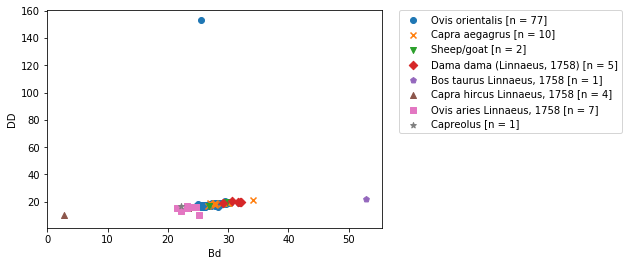

In [20]:
oc_plt.key_x_axis = 'Bd'
oc_plt.key_y_axis = 'DD'
oc_plt.key_type = 'Has Biological Taxonomy'
oc_plt.make_records_scatter_plot(records)

## Now remove some of the outliers
We probably have some measurement and/or recording errors. The "y_max_ok" attribute is the
maximum value for y ("DD") values that we'll accept for plotting.

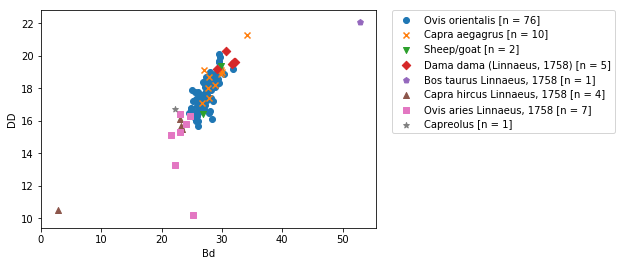

In [6]:
oc_plt = OpenContextPlot()
oc_plt.key_x_axis = 'Bd'
oc_plt.key_y_axis = 'DD'
oc_plt.key_type = 'Has Biological Taxonomy'
oc_plt.y_max_ok = 40
oc_plt.make_records_scatter_plot(records)


Now to try another scatter plot, looking at measurements from the proximal end of the bone rather than the distal.

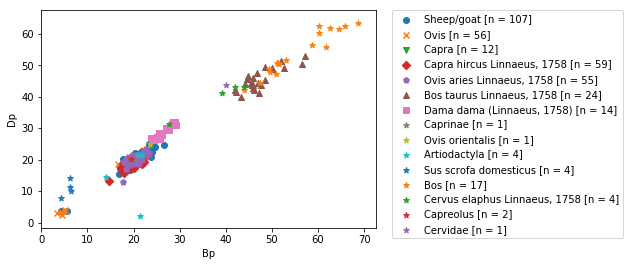

In [18]:
oc_plt = OpenContextPlot()
oc_plt.key_x_axis = 'Bp'
oc_plt.key_y_axis = 'Dp'
oc_plt.key_type = 'Has Biological Taxonomy'
oc_plt.make_records_scatter_plot(records)

# Make some other plots

Knowing what you now know, can you make some other comparitive scatterplots using this data? (Hint: [take a look at this](https://opencontext.org/vocabularies/open-context-zooarch/von-den-driesch-bone-meas)). Remember also how to look at the underlying json representation of the data. Are there any fields that you could pass into the x and y axis to make a scatterplot?

Can you create a new search url for open context and use this notebook to retrieve and visualize the data?